In [1]:
# Bibliotecas utilizadas nesse projeto
# Parte estatística
import pandas as pd
import numpy as np
import openpyxl as xl # para leitura de arquivos xlm e xlsx
from scipy import stats # para testes de hipótese

# Parte Gráfica
import matplotlib.pyplot as plt
import seaborn as sns

# Parte de modelagem
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Explorando os dados

In [2]:
# Importando a base para o python
df = pd.read_excel('dataset_desafio_trainees.xlsx')
df_alunos = df.copy() # cria uma cópia para não alterar o origanal

In [3]:
# Verificando a quantidade de linhas e colunas
df_alunos.shape

(86, 7)

In [4]:
# verificando tipo de cada coluna e se há dados faltantes
df_alunos.info() # não temos dados faltantes nesse dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   nome_aluno        86 non-null     object
 1   matricula         86 non-null     int64 
 2   email             86 non-null     object
 3   horas_estudo      86 non-null     int64 
 4   aulas_assistidas  86 non-null     int64 
 5   faltas            86 non-null     int64 
 6   nota_final        86 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 4.8+ KB


In [5]:
# verificando se há alunos duplicados na base
len(df_alunos["matricula"].unique()) # não há alunos duplicados

86

In [6]:
# Visualizando as 5 primeiras linhas
df_alunos.head()

,nome_aluno,matricula,email,horas_estudo,aulas_assistidas,faltas,nota_final
0,Helena Lima,20240001,helena.lima1@exemplo.com,2,40,10,45
1,Gabriel Oliveira,20240002,gabriel.oliveira2@exemplo.com,3,45,9,48
2,Gabriel Ribeiro,20240003,gabriel.ribeiro3@exemplo.com,4,50,9,50
3,Ana Silva,20240004,ana.silva4@exemplo.com,5,55,8,53
4,Daniela Lima,20240005,daniela.lima5@exemplo.com,6,58,8,56


# 2. Estatísticas descritivas

In [7]:
# Estatísticas descritivas
df.loc[:, ['nota_final', 'horas_estudo', 'aulas_assistidas', 'faltas']].describe()

,nota_final,horas_estudo,aulas_assistidas,faltas
count,86.000000,86.000000,86.000000,86.000000
mean,73.674419,14.186047,75.883721,4.465116
std,13.947331,6.434304,14.492528,2.509735
min,45.000000,2.000000,40.000000,0.000000
25%,63.000000,9.000000,66.000000,2.250000
50%,74.500000,14.000000,77.000000,4.000000
75%,85.000000,19.750000,87.750000,6.000000
max,98.000000,26.000000,100.000000,10.000000


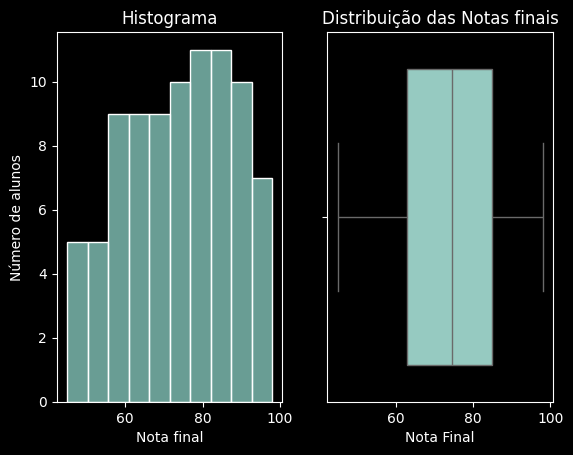

In [98]:
# construindo um boxsplot apenas para verificar a dispersão dos dados
#Histograma
plt.subplot(1,2,1)
hist = sns.histplot(data = df_alunos, x = "nota_final", bins= 10)
hist.set_xlabel("Nota final")
hist.set_ylabel("Número de alunos")
hist.set_title("Histograma")

#Boxplot
plt.subplot(1,2,2)
box = sns.boxplot( x = df_alunos["nota_final"])
box.set_xlabel("Nota Final")
box.set_title("Distribuição das Notas finais")
plt.show()

## Interpretação das estatísticas descritivas

Não temos diferenças significativas entre as estatísticas descritivas calculadas no Excel contra as calculadas no Python.

A maior nota foi 98 e a menor 45, uma amplitude de 53 pontos.

Como a mediana (74.5) é ligeiramente maior que a média (73.67), temos uma leve assimetria à esquerda indicando que há  algumas notas mais baixas (como o mínimo de 45) que estão puxando a média para baixo.
Além disso, há um desvio de aproximadamente 14 pontos que sugere uma turma heterogênea, ou seja, existem alunos que estão indo muito bem e os que estão com dificuldade.

De modo geral é uma turma com bom desempenho geral, já que a maioria (75%) tirou acima de 63 pontos.

# 3. Verificando a Correlação entre as variáveis

<Axes: >

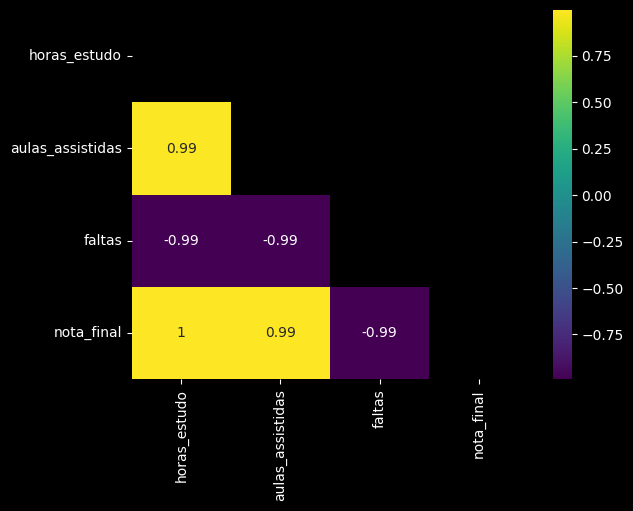

In [99]:
# Correlação entre as variaveis
#cor = sns.heatmap(df_alunos.loc[:, ['horas_estudo', 'aulas_assistidas',
#       'faltas', 'nota_final']].corr(),cmap="viridis", annot=True)
cor = df_alunos.loc[:, ['horas_estudo', 'aulas_assistidas','faltas', 'nota_final']].corr()
# Criando uma máscara para mostrar apenas a parte da matriz de correlação
mask = np.zeros_like(cor) 
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cor, cmap= "viridis", annot = True, mask = mask)


## Interpretação das Correlações 
### Correlações Positivas Fortes (Amarelo)
Quando uma variável aumenta, a outra também aumenta quase na mesma proporção.

Horas de Estudo X Nota Final (Correlação = 1): estas variáveis apresentam uma correlação positiva perfeita. Indicando que, quanto mais tempo o aluno dedica ao estudo, maior é sua nota final.

Aulas Assistidas X Nota Final (Correlação = 0,99): estas variáveis apresentam uma correlação quase perfeita. Sugerindo que a presença e participação nas aulas estão diretamente ligadas a uma maior nota final.

# 4. Teste de hipótese

In [100]:
# Realizar o teste de hipotese 

# Grupo 1: Alunos que estudam até 10h semanais
grupo_ate_10h = df_alunos[df_alunos['horas_estudo']<=10]['nota_final']

# Grupo 2: Alunos que estudam mais de 10h semanais
grupo_mais_10h = df_alunos[df_alunos['horas_estudo']>10]['nota_final']

# Realizando o teste de Shapiro - Wilk -> Determinar se os dados são normalmente distribuídos, fundamental para análises como testes t
shapiro_a = stats.shapiro(grupo_ate_10h)
shapiro_b = stats.shapiro(grupo_mais_10h)

# Como o p-valor é maior que alfa nos dois testes de Shapiro, sendo assim podemos concluir que os dados de ambos os grupos
# são oriundos de uma população com distribuição normal(essa informaçã oé importante para sabermos se podemos aplicar o teste T). 

In [101]:
# verificando a média dos dois grupos
print(f"Média Grupo Até 10h: {grupo_ate_10h.mean():.2f}")
print(f"Média Grupo Mais 10h: {grupo_mais_10h.mean():.2f}")

Média Grupo Até 10h: 57.18
Média Grupo Mais 10h: 81.64


In [102]:
# H0 (Hipótese Nula): As médias das notas são iguais.
# H1 (Hipótese Alternativa): A média do grupo que estuda > 10h é maior.
# Utilizamos o argumento alternative='greater' no código pois a hipótese não é apenas que as notas são diferentes,
# mas sim que as de quem estuda mais são maiores
t_stat, p_valor = stats.ttest_ind(grupo_mais_10h, grupo_ate_10h, alternative='greater')

if p_valor < 0.05:
    print("Resultado: Rejeitamos a Hipótese Nula. Há evidências de que estudar mais de 10h aumenta a nota.")
else:
    print("Resultado: Não há evidências estatísticas suficientes para afirmar que a nota é maior.")

Resultado: Rejeitamos a Hipótese Nula. Há evidências de que estudar mais de 10h aumenta a nota.


## Interpretação teste de Hipótese
A escolha de dividir os alunos exatamente em "Até 10h" e "Mais de 10h" foi feita para transformar uma variável contínua (horas_estudo) em uma variável categórica binária(até_10h e mais_10h), permitindo a comparação de médias entre dois grupos distintos.

Além disso, chegampos ao resultado de que rejeitamos a Hipótese Nula. Pois há evidências(p-valor<0.05) de que estudar mais de 10h aumenta a nota.

# 5. Aplicando o modelo de regressão Linear

In [156]:
# Setando uma semente de reprodutibilidade
np.random.seed(42)

# Variaveis preditoras
# As variaveis 'nome_aluno', 'matricula' e 'email' não serão utilizadas no modelo de predição
X = df_alunos.iloc[: , 3:6] # regressaão linear multipla (Mas esse caso esbarra na multicolinearidade)
#X = df_alunos.iloc[: , 3].values.reshape(-1,1) #regressão linear simples

# Variável alvo ('nota_final')
y = df_alunos.iloc[: , -1]


In [157]:
# Dividindo o conjunto de dados em teste e treino (será utilizado 80% para treino e 20% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# verificando a divisão
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((68, 3), (18, 3), (68,), (18,))

In [158]:
# Criando o modelo de regressão
model = LinearRegression()

# Treinamento do modelo
model.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [159]:
# Utilizando o modelo criado para realizar previsões 
y_pred = model.predict(X_test)

In [160]:
# Verificando a metricas obtidas
r_quadrado = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R-quadrado (R²):{r_quadrado:.4f}")
print(f"Erro quadrado médio (MSE): {mse:.8f}")
print(f"Erro absoluto médio (MAE): {mae:.8f}")

R-quadrado (R²):0.9982
Erro quadrado médio (MSE): 0.33940353
Erro absoluto médio (MAE): 0.42174985


In [161]:
# valores para regressão simples
# R-quadrado (R²):0.9941
# Erro quadrado médio (MSE): 1.12586480
# Erro absoluto médio (MAE): 0.86529245

In [149]:
# Valores para a equação de regressão Linear do modelo
coef = model.coef_.round(2)
intercpt = model.intercept_.round(2)
print(coef)
print(intercpt)

[ 1.07  0.39 -0.61]
31.87


### Equação de regressão linear
$y(Nota final) = 1.07x_1 + 0.39x_2 - 0.61x_3 + 31.87$

onde: $x_1$ = horas de estudo; $x_2$ = aulas assistidas; $x_3$ = faltas

## Interpreteção da Regressão
$\textbf{Mean Square Error (MSE) - Erro Quadrático Médio:}$ É a média dos quadrados dos erros. O erro é a diferença entre o valor real ($y$) e o valor previsto ($\hat{y}$) pelo modelo.

Sendo utilizado para medir o quão próximos os valores previstos estão dos reais. Por elevar o erro ao quadrado, o MSE penaliza severamente erros grandes, tornando-o ideal se você quer evitar grandes desvios a qualquer custo.

$$\text{Fórmula:}$$ $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$


$\textbf{Mean Absolute Error (MAE) - Erro Absoluto Médio:}$ É a média das diferenças absolutas entre os valores reais e previstos. 

Esta métrica fornece uma medida linear da magnitude do erro em uma escala que é fácil de interpretar (na mesma unidade dos dados originais). Ao contrário do MSE, ele não penaliza tanto os outliers, tratando todos os erros de forma proporcional.

$$\text{Fórmula:}$$ $$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

$\textbf{R2 Score (Coeficiente de Determinação):}$ É uma métrica estatística que representa a porcentagem da variância da variável dependente que é explicada pelo modelo, sendo utilizado para verificar a qualidade do ajuste. 
$$\text{Fórmula:}$$ $$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$
Onde $SS_{res}$ é a soma dos quadrados dos resíduos e $SS_{tot}$ é a soma total dos quadrados

$\textbf{Como essas métricas avaliam o desempenho?}$ 

Tais métricas fornecem um diagnóstico do modelo

MSE/MAE baixos: Indicam que o modelo está errando pouco. Se o MSE estiver muito maior que o MAE, você sabe que tem alguns erros muito grandes (outliers) incomodando o modelo.

R2 Score alto: Indica que o modelo captura bem a tendência dos dados. Se o seu $R^2$ for baixo, a sua linha de regressão não está conseguindo "explicar" o que acontece com os dados.

$\textbf{Divisão de dados:}$

Ao usar a função train_test_split, dividimos o dataset em quatro partes:

x_train: As características que o modelo usará para aprender.

y_train: As respostas corretas que o modelo usa para ajustar seus parâmetros.

x_test: Dados novos que o modelo nunca viu, usados para fazer previsões após o treino.

y_test: As respostas reais do teste, usadas para comparar com as previsões e calcular o MSE, MAE e $R^2$.

E a função train_test_split realiza essa divisão para evitar o Overfitting (sobreajuste). Se testarmos o modelo com os mesmos dados que usamos para treiná-lo, ele pode simplesmente decorar os dados em vez de aprender a lógica por trás deles.

Dividir os dados nos permite simular o mundo real: treinando o modelo e verificamos se ele consegue prever com precisão.